# Visual Search with OpenAI CLIP

SentenceTransformers provides models that allow to embed images and text into the same vector space. This allows to find similar images as well as to implement image search. We can define a query using text or using a reference image.

https://www.sbert.net/examples/applications/image-search/README.html

## 1. Required librairies

In [1]:
#!pip install sentence_transformers

In [2]:
#!pip install ftfy

In [3]:
import glob
import torch
import os
import time
import json
import pickle
import os.path
import urllib

from PIL import Image
from IPython.display import display
from IPython.display import Image as IPDImage
from tqdm.autonotebook import tqdm
from zipfile import ZipFile as ZP

from sentence_transformers import SentenceTransformer, util

In [4]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [5]:
import datetime
Current_Date_Formatted = datetime.datetime.today().strftime ('%d-%b-%Y')
print ('Current Date: ' + str(Current_Date_Formatted))

Current Date: 19-Sep-2022


## 2. Images

We are going to donwload some images

In [6]:
download_url = "https://github.com/retkowsky/visual_search_openai_clip/raw/main/images.zip"
zip_file = "images.zip"

t1 = time.time()
print("Downloading the images zip file...")
urllib.request.urlretrieve(download_url, filename=zip_file)
print("\nDone in", round(time.time() - t1, 2), "secs")


Done in 0.97 secs


In [7]:
!ls *.zip -lh

-rwxrwxrwx 1 root root 25M Sep 19 12:37 images.zip


In [8]:
img_folder = "images"

Now let's unzip the images file

In [9]:
t1 = time.time()

if not os.path.exists(img_folder):
    try:
        with ZP(zip_file, 'r') as zip:
            print("Unzipping the zip file:", zip_file)
            zip.extractall()
        print("Done")
    
    except:
        print("Error")
    
    print("\nDeleting the zip file:", zip_file)
    os.remove(zip_file)
    print("Done")

    print("\nFull process done in", round((time.time() - t1) / 60, 2), "min")

Unzipping the zip file: images.zip
Done

Deleting the zip file: images.zip
Done

Full process done in 1.8 min


We have a total of 1006 images

In [10]:
nbfiles = sum(len(files) for _, _, files in os.walk(img_folder))
print("Number of files in the directory", img_folder, "=", nbfiles)

Number of files in the directory images = 1006


## 3. Model specification and Images embedding

Now we can specify a CLIP model to use and we will apply it to all our images

https://www.sbert.net/docs/pretrained_models.html#image-text-models

https://huggingface.co/sentence-transformers/clip-ViT-B-32

In [11]:
clipmodel = 'clip-ViT-B-32'

model = SentenceTransformer(clipmodel)
print("We will use model:", clipmodel)

We will use model: clip-ViT-B-32


In [12]:
imageslist = [file for file in glob.glob(img_folder + '/*.*') 
              if file.endswith(('jpeg', 'png', 'jpg', 'JPEG', 'PNG', 'JPG'))]

In [13]:
# Some images links from the list
imageslist[:10]

['images/img (1).jpg',
 'images/img (10).jpg',
 'images/img (100).jpg',
 'images/img (1000).jpg',
 'images/img (1001).jpg',
 'images/img (1002).jpg',
 'images/img (1003).jpg',
 'images/img (1004).jpg',
 'images/img (1005).jpg',
 'images/img (1006).jpg']

In [14]:
print("Number of images in the list =", len(imageslist))

Number of images in the list = 1006


Now it is time to process all the images

In [15]:
# Name of the model to create or to use
mymodel = "mymodelv1.pkl"

In [16]:
if os.path.exists(mymodel):
    try:
        print("Loading pkl file:", mymodel) # We can load the pkl file

        with open(mymodel, 'rb') as f:
            image_emb = pickle.load(f)

        print("Model embedding loaded!")

    except:
        print("Error when loading the pkl file", mymodel)

else:
    t1 = time.time()
    
    try:
        print("Processing images...") # We are going to encode each image file
        image_emb = model.encode([Image.open(filename) 
                                  for filename in imageslist],
                                 batch_size=64,
                                 convert_to_tensor=True,
                                 show_progress_bar=True)

        print("Saving model into", mymodel) # we can save the embedded results
        with open(mymodel,'wb') as f:
            pickle.dump(image_emb, f)

        print("\nDone in", round((time.time() - t1) / 60, 2), "min.")
        print("Time for processing 1 image =", round((time.time() - t1) / len(imageslist), 5), "seconds.")

    except:
        print('Error during the processing of the images')


Processing images...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Saving model into mymodelv1.pkl

Done in 1.21 min.
Time for processing 1 image = 0.07188 seconds.


We can check the saved model

In [17]:
!ls *.pkl -lh

-rwxrwxrwx 1 root root 2.0M Sep 19 12:40 mymodelv1.pkl


## 4. Search function

In [18]:
def search(query, topn=3, size=250):

    t1 = time.time()

    # First, we encode the query 
    # (which can either be an image or a text string)
    query_emb = model.encode([query], 
                             convert_to_tensor=True, 
                             show_progress_bar=False)

    # Then, we use the util.semantic_search function
    #, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    results = util.semantic_search(query_emb, 
                                   image_emb, 
                                   top_k=topn)[0]

    print("Your query:", query)
    print("\nResults:\n")

    nbimages = 1

    for result in results:
        print(nbimages, "- Catalog image ID:", 
              imageslist[result['corpus_id']], 
              " with score =", round(result['score'], 5), "\n")
        
        display(IPDImage(imageslist[result['corpus_id']], 
                         width=size))

        nbimages += 1

    print("\nDone in", round(time.time() - t1, 5), "secs")

    return results

### Logic

In [19]:
query = 'green car'

query_emb = model.encode([query], 
                         convert_to_tensor=True, 
                         show_progress_bar=False)

results = util.semantic_search(query_emb, 
                               image_emb, 
                               top_k=3)[0]

print("Results:")
print(json.dumps(results, indent=3))

Results:
[
   {
      "corpus_id": 43,
      "score": 0.2982797622680664
   },
   {
      "corpus_id": 57,
      "score": 0.2869340479373932
   },
   {
      "corpus_id": 82,
      "score": 0.2866455018520355
   }
]


## 5. Testing

We can test the search capabilty using some open free text or using a reference image to find all the similar images from our catalog of images

### Testing using text query

Your query: Tour Eiffel

Results:

1 - Catalog image ID: images/img (974).jpg  with score = 0.31114 



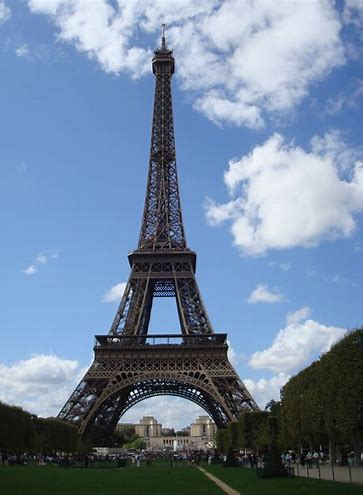

2 - Catalog image ID: images/img (991).jpg  with score = 0.30522 



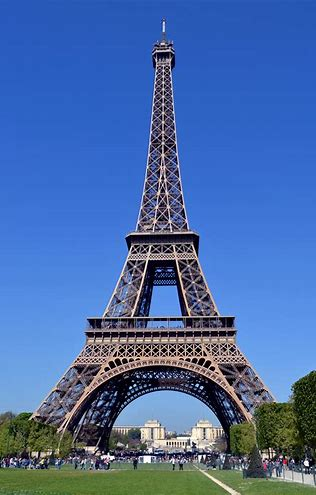

3 - Catalog image ID: images/img (992).jpg  with score = 0.30504 



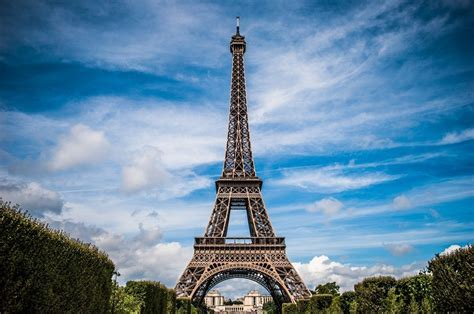


Done in 0.15368 secs


[{'corpus_id': 978, 'score': 0.31114357709884644},
 {'corpus_id': 997, 'score': 0.3052155375480652},
 {'corpus_id': 998, 'score': 0.3050445318222046}]

In [20]:
search("Tour Eiffel")

Your query: Arc de triomphe

Results:

1 - Catalog image ID: images/img (979).jpg  with score = 0.33682 



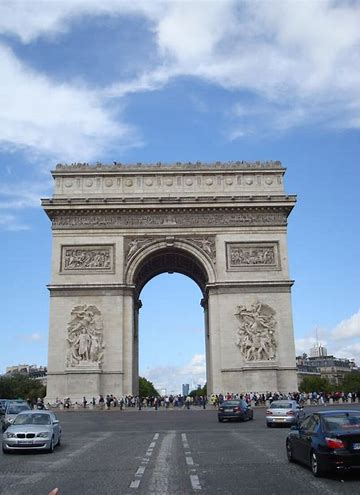

2 - Catalog image ID: images/img (12).jpg  with score = 0.32178 



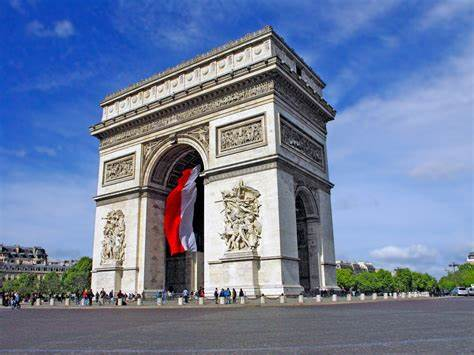

3 - Catalog image ID: images/img (972).jpg  with score = 0.31789 



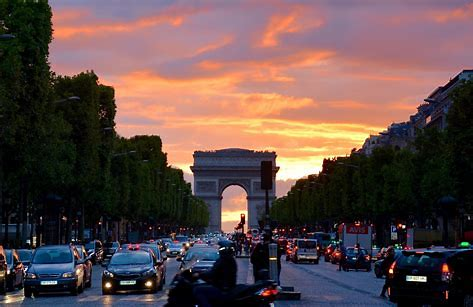


Done in 0.15101 secs


[{'corpus_id': 983, 'score': 0.33681586384773254},
 {'corpus_id': 37, 'score': 0.32177650928497314},
 {'corpus_id': 976, 'score': 0.3178870677947998}]

In [21]:
search("Arc de triomphe")

Your query: Musée du Louvre

Results:

1 - Catalog image ID: images/img (990).jpg  with score = 0.30649 



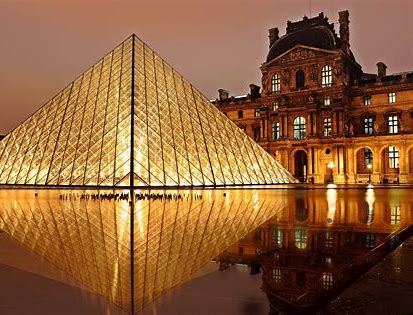

2 - Catalog image ID: images/img (975).jpg  with score = 0.30247 



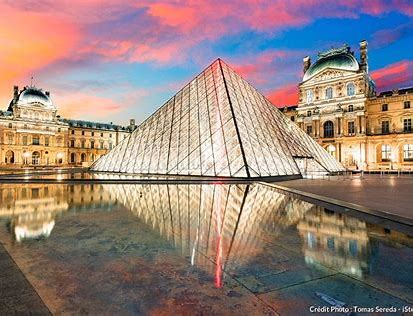


Done in 0.12015 secs


[{'corpus_id': 996, 'score': 0.30649182200431824},
 {'corpus_id': 979, 'score': 0.30247414112091064}]

In [22]:
search("Musée du Louvre", 2)

Your query: Paris by night

Results:

1 - Catalog image ID: images/img (989).jpg  with score = 0.30717 



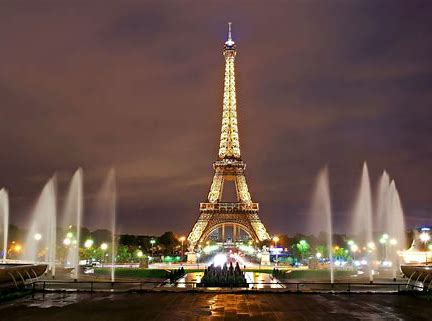

2 - Catalog image ID: images/img (993).jpg  with score = 0.28768 



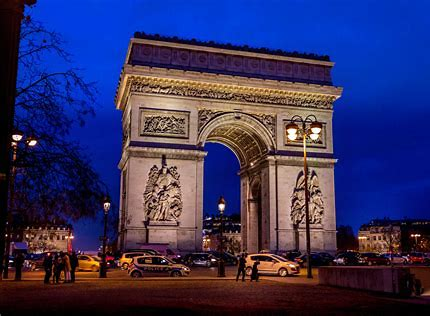

3 - Catalog image ID: images/img (981).jpg  with score = 0.28451 



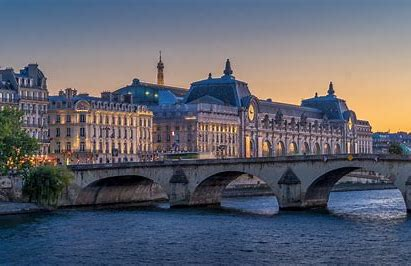


Done in 0.22187 secs


[{'corpus_id': 994, 'score': 0.30717039108276367},
 {'corpus_id': 999, 'score': 0.28768298029899597},
 {'corpus_id': 986, 'score': 0.2845081090927124}]

In [23]:
search("Paris by night")

Your query: show me an elephant

Results:

1 - Catalog image ID: images/img (232).jpg  with score = 0.29578 



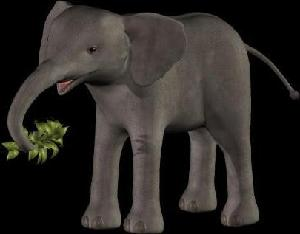

2 - Catalog image ID: images/img (223).jpg  with score = 0.28978 



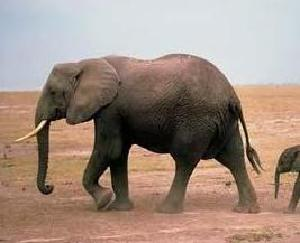

3 - Catalog image ID: images/img (233).jpg  with score = 0.28309 



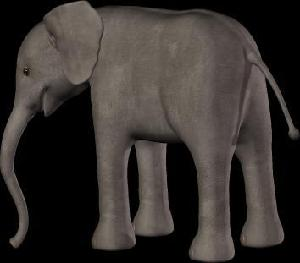


Done in 0.15764 secs


[{'corpus_id': 159, 'score': 0.29577895998954773},
 {'corpus_id': 149, 'score': 0.2897791862487793},
 {'corpus_id': 160, 'score': 0.28309449553489685}]

In [24]:
search("show me an elephant")

Your query: show me a dalmatian

Results:

1 - Catalog image ID: images/img (292).jpg  with score = 0.32898 



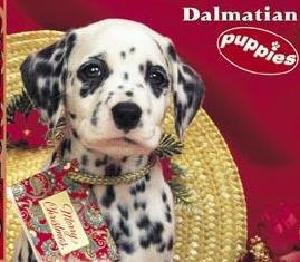

2 - Catalog image ID: images/img (302).jpg  with score = 0.32759 



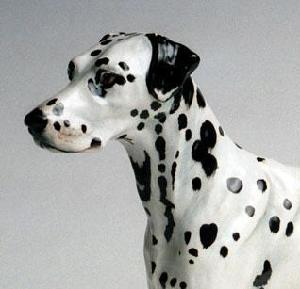

3 - Catalog image ID: images/img (327).jpg  with score = 0.32114 



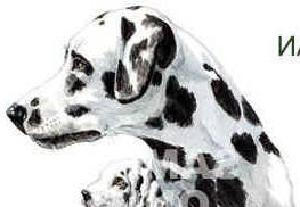


Done in 0.17475 secs


[{'corpus_id': 225, 'score': 0.3289751410484314},
 {'corpus_id': 237, 'score': 0.3275895416736603},
 {'corpus_id': 264, 'score': 0.3211447596549988}]

In [25]:
search("show me a dalmatian")

Your query: show me a green car

Results:

1 - Catalog image ID: images/img (125).jpg  with score = 0.30151 



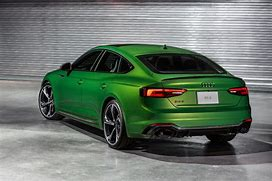

2 - Catalog image ID: images/img (138).jpg  with score = 0.27784 



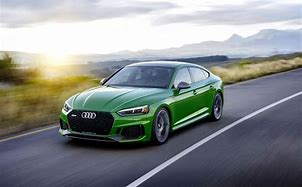

3 - Catalog image ID: images/img (163).jpg  with score = 0.27276 



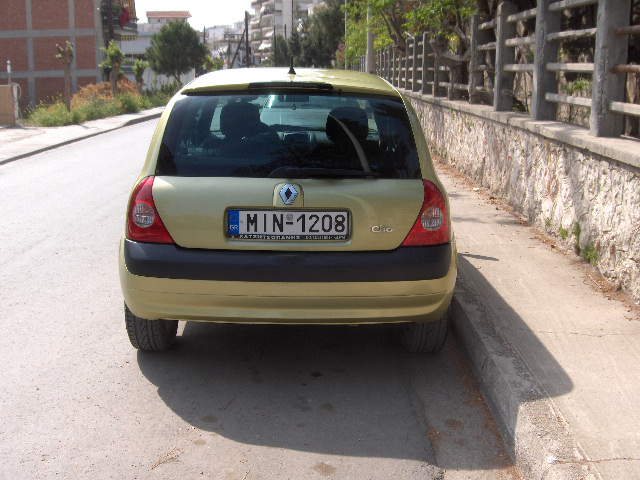


Done in 0.15574 secs


[{'corpus_id': 43, 'score': 0.30151233077049255},
 {'corpus_id': 57, 'score': 0.27783650159835815},
 {'corpus_id': 82, 'score': 0.2727646827697754}]

In [26]:
search("show me a green car")

Your query: show me an acoustic guitar

Results:

1 - Catalog image ID: images/img (896).jpg  with score = 0.29943 



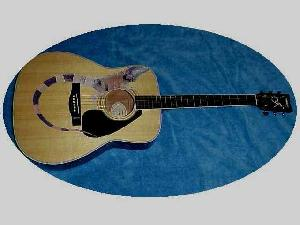

2 - Catalog image ID: images/img (879).jpg  with score = 0.29298 



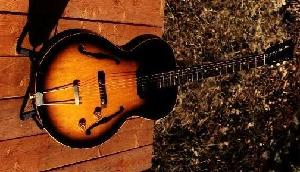

3 - Catalog image ID: images/img (884).jpg  with score = 0.29224 



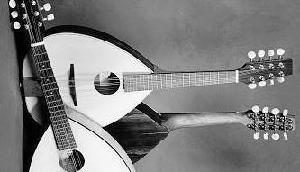


Done in 0.15004 secs


[{'corpus_id': 891, 'score': 0.299434632062912},
 {'corpus_id': 872, 'score': 0.29298216104507446},
 {'corpus_id': 878, 'score': 0.2922440767288208}]

In [27]:
search("show me an acoustic guitar")

Your query: show me a blue electric guitar

Results:

1 - Catalog image ID: images/img (858).jpg  with score = 0.33066 



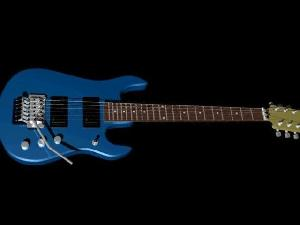

2 - Catalog image ID: images/img (869).jpg  with score = 0.3296 



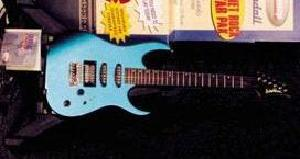

3 - Catalog image ID: images/img (888).jpg  with score = 0.32528 



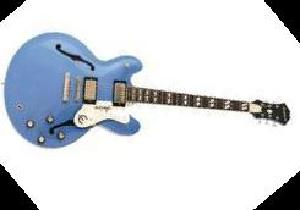


Done in 0.14589 secs


[{'corpus_id': 849, 'score': 0.33066439628601074},
 {'corpus_id': 861, 'score': 0.329600989818573},
 {'corpus_id': 882, 'score': 0.3252770006656647}]

In [28]:
search("show me a blue electric guitar")

Your query: show me a Gibson guitar

Results:

1 - Catalog image ID: images/img (959).jpg  with score = 0.31166 



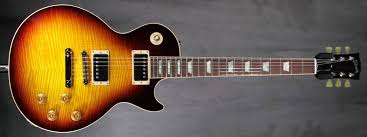

2 - Catalog image ID: images/img (958).jpg  with score = 0.30922 



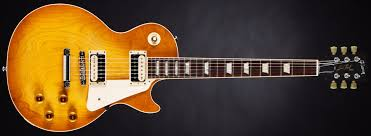

3 - Catalog image ID: images/img (963).jpg  with score = 0.30897 



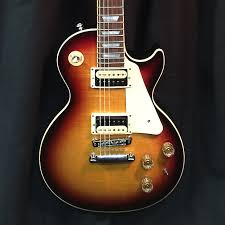


Done in 0.1498 secs


[{'corpus_id': 961, 'score': 0.31165510416030884},
 {'corpus_id': 960, 'score': 0.3092195987701416},
 {'corpus_id': 966, 'score': 0.3089650571346283}]

In [29]:
search("show me a Gibson guitar")

Your query: show me a flying v

Results:

1 - Catalog image ID: images/img (5).jpg  with score = 0.32226 



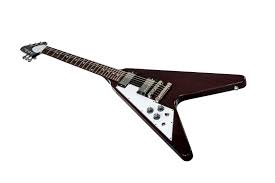

2 - Catalog image ID: images/img (8).jpg  with score = 0.31849 



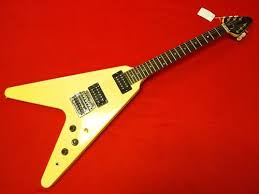

3 - Catalog image ID: images/img (883).jpg  with score = 0.30617 



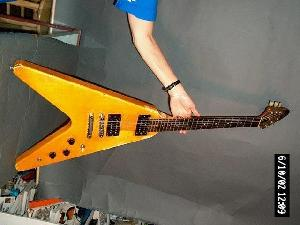


Done in 0.14644 secs


[{'corpus_id': 454, 'score': 0.32226336002349854},
 {'corpus_id': 787, 'score': 0.31848812103271484},
 {'corpus_id': 877, 'score': 0.3061675429344177}]

In [30]:
search("show me a flying v")

Your query: show me a fender telecaster

Results:

1 - Catalog image ID: images/img (1009).jpg  with score = 0.33811 



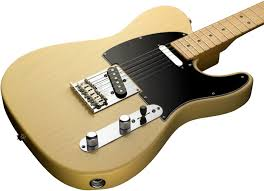

2 - Catalog image ID: images/img (1012).jpg  with score = 0.32691 



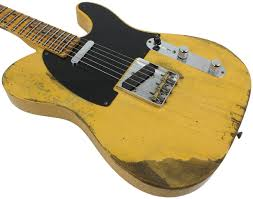

3 - Catalog image ID: images/img (1013).jpg  with score = 0.32597 



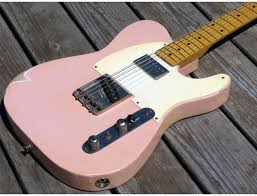


Done in 0.14 secs


[{'corpus_id': 12, 'score': 0.3381102681159973},
 {'corpus_id': 16, 'score': 0.32690876722335815},
 {'corpus_id': 17, 'score': 0.3259658217430115}]

In [31]:
search("show me a fender telecaster")

Your query: show me a man with glasses

Results:

1 - Catalog image ID: images/img (570).jpg  with score = 0.25635 



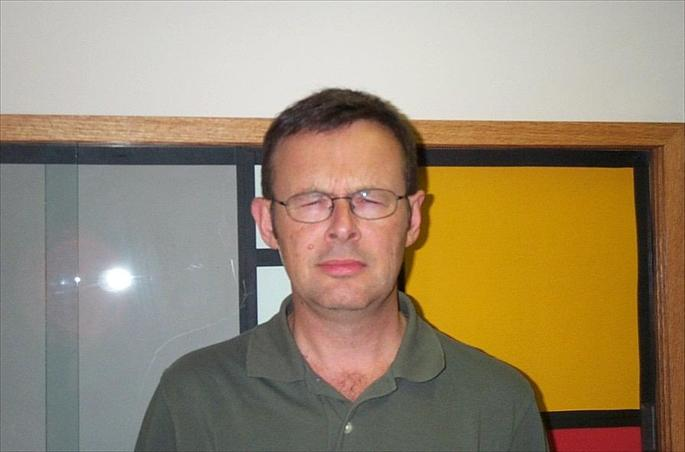

2 - Catalog image ID: images/img (571).jpg  with score = 0.25246 



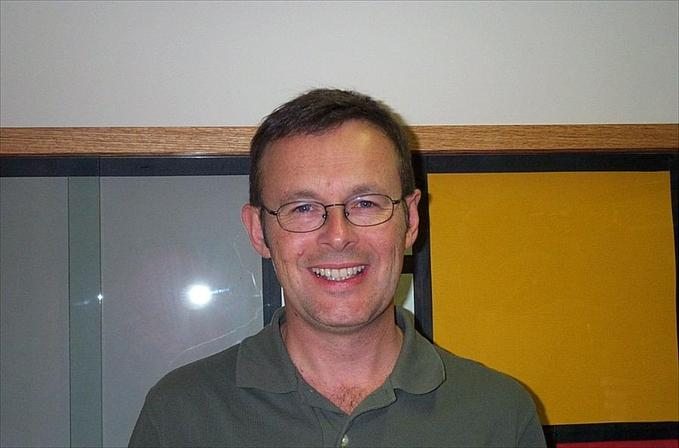

3 - Catalog image ID: images/img (568).jpg  with score = 0.25062 



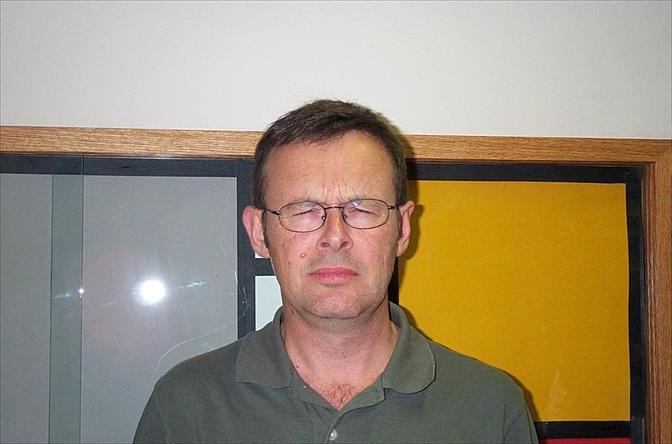


Done in 0.15962 secs


[{'corpus_id': 533, 'score': 0.2563498616218567},
 {'corpus_id': 534, 'score': 0.25245949625968933},
 {'corpus_id': 530, 'score': 0.25062093138694763}]

In [32]:
search("show me a man with glasses")

Your query: show me an audi car

Results:

1 - Catalog image ID: images/img (125).jpg  with score = 0.29073 



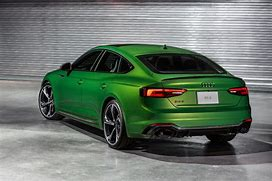

2 - Catalog image ID: images/img (135).jpg  with score = 0.28775 



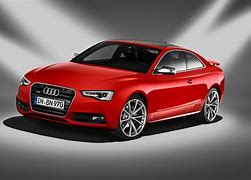

3 - Catalog image ID: images/img (133).jpg  with score = 0.28505 



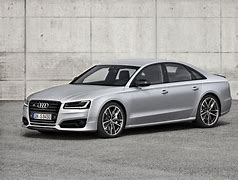


Done in 0.15217 secs


[{'corpus_id': 43, 'score': 0.2907288670539856},
 {'corpus_id': 54, 'score': 0.287747323513031},
 {'corpus_id': 52, 'score': 0.28505420684814453}]

In [33]:
search("show me an audi car")

Your query: BMW car

Results:

1 - Catalog image ID: images/img (148).jpg  with score = 0.30123 



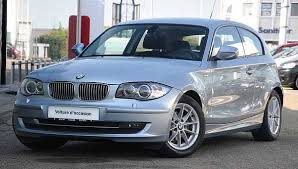

2 - Catalog image ID: images/img (151).jpg  with score = 0.29775 



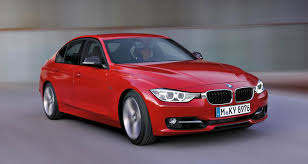

3 - Catalog image ID: images/img (153).jpg  with score = 0.2935 



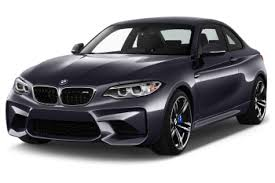


Done in 0.1546 secs


[{'corpus_id': 67, 'score': 0.3012332320213318},
 {'corpus_id': 71, 'score': 0.29774734377861023},
 {'corpus_id': 73, 'score': 0.2935011386871338}]

In [34]:
search("BMW car")

Your query: Rolls Royce car

Results:

1 - Catalog image ID: images/img (922).jpg  with score = 0.3285 



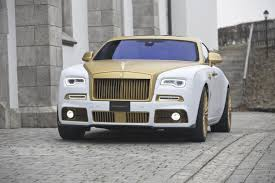

2 - Catalog image ID: images/img (917).jpg  with score = 0.32433 



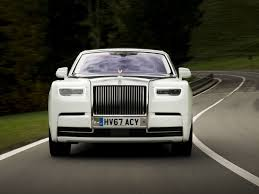

3 - Catalog image ID: images/img (920).jpg  with score = 0.31963 



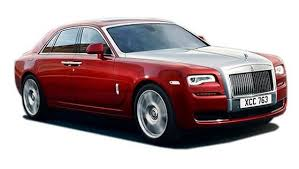


Done in 0.20807 secs


[{'corpus_id': 921, 'score': 0.3284991979598999},
 {'corpus_id': 915, 'score': 0.32433414459228516},
 {'corpus_id': 919, 'score': 0.3196309208869934}]

In [35]:
search("Rolls Royce car")

Your query: glacier

Results:

1 - Catalog image ID: images/img (37).jpg  with score = 0.30167 



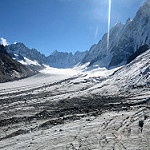

2 - Catalog image ID: images/img (39).jpg  with score = 0.29379 



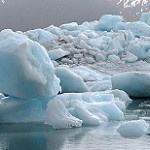

3 - Catalog image ID: images/img (66).jpg  with score = 0.29271 



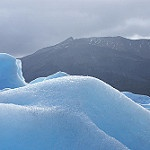


Done in 0.17118 secs


[{'corpus_id': 311, 'score': 0.3016664385795593},
 {'corpus_id': 333, 'score': 0.29379281401634216},
 {'corpus_id': 632, 'score': 0.29270896315574646}]

In [36]:
search("glacier")

Your query: forest

Results:

1 - Catalog image ID: images/img (84).jpg  with score = 0.2962 



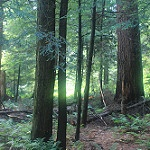

2 - Catalog image ID: images/img (63).jpg  with score = 0.28593 



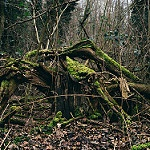

3 - Catalog image ID: images/img (35).jpg  with score = 0.28495 



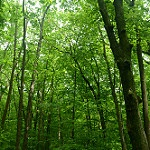


Done in 0.15995 secs


[{'corpus_id': 832, 'score': 0.2962026596069336},
 {'corpus_id': 599, 'score': 0.2859254479408264},
 {'corpus_id': 289, 'score': 0.2849518358707428}]

In [37]:
search("forest")

Your query: show me a cruise boat

Results:

1 - Catalog image ID: images/img (104).jpg  with score = 0.27365 



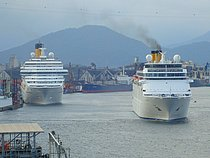

2 - Catalog image ID: images/img (107).jpg  with score = 0.269 



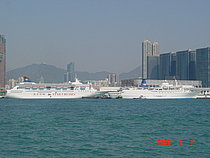

3 - Catalog image ID: images/img (106).jpg  with score = 0.26644 



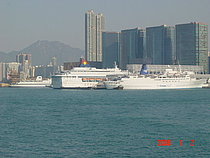


Done in 0.14557 secs


[{'corpus_id': 20, 'score': 0.2736489176750183},
 {'corpus_id': 23, 'score': 0.2689979076385498},
 {'corpus_id': 22, 'score': 0.2664368450641632}]

In [38]:
search("show me a cruise boat")

Your query: tanker

Results:

1 - Catalog image ID: images/img (113).jpg  with score = 0.31485 



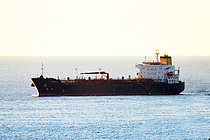

2 - Catalog image ID: images/img (110).jpg  with score = 0.30968 



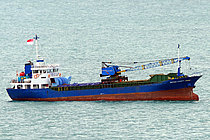

3 - Catalog image ID: images/img (111).jpg  with score = 0.30837 



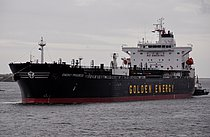


Done in 0.14607 secs


[{'corpus_id': 30, 'score': 0.3148524761199951},
 {'corpus_id': 27, 'score': 0.3096753656864166},
 {'corpus_id': 28, 'score': 0.3083694279193878}]

In [39]:
search("tanker")

Your query: UK flag

Results:

1 - Catalog image ID: images/img (887).jpg  with score = 0.29843 



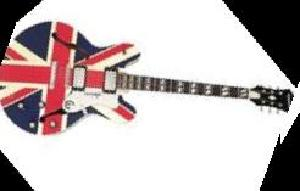


Done in 0.07993 secs


[{'corpus_id': 881, 'score': 0.29842671751976013}]

In [40]:
search("UK flag", 1)

### Testing using a reference image

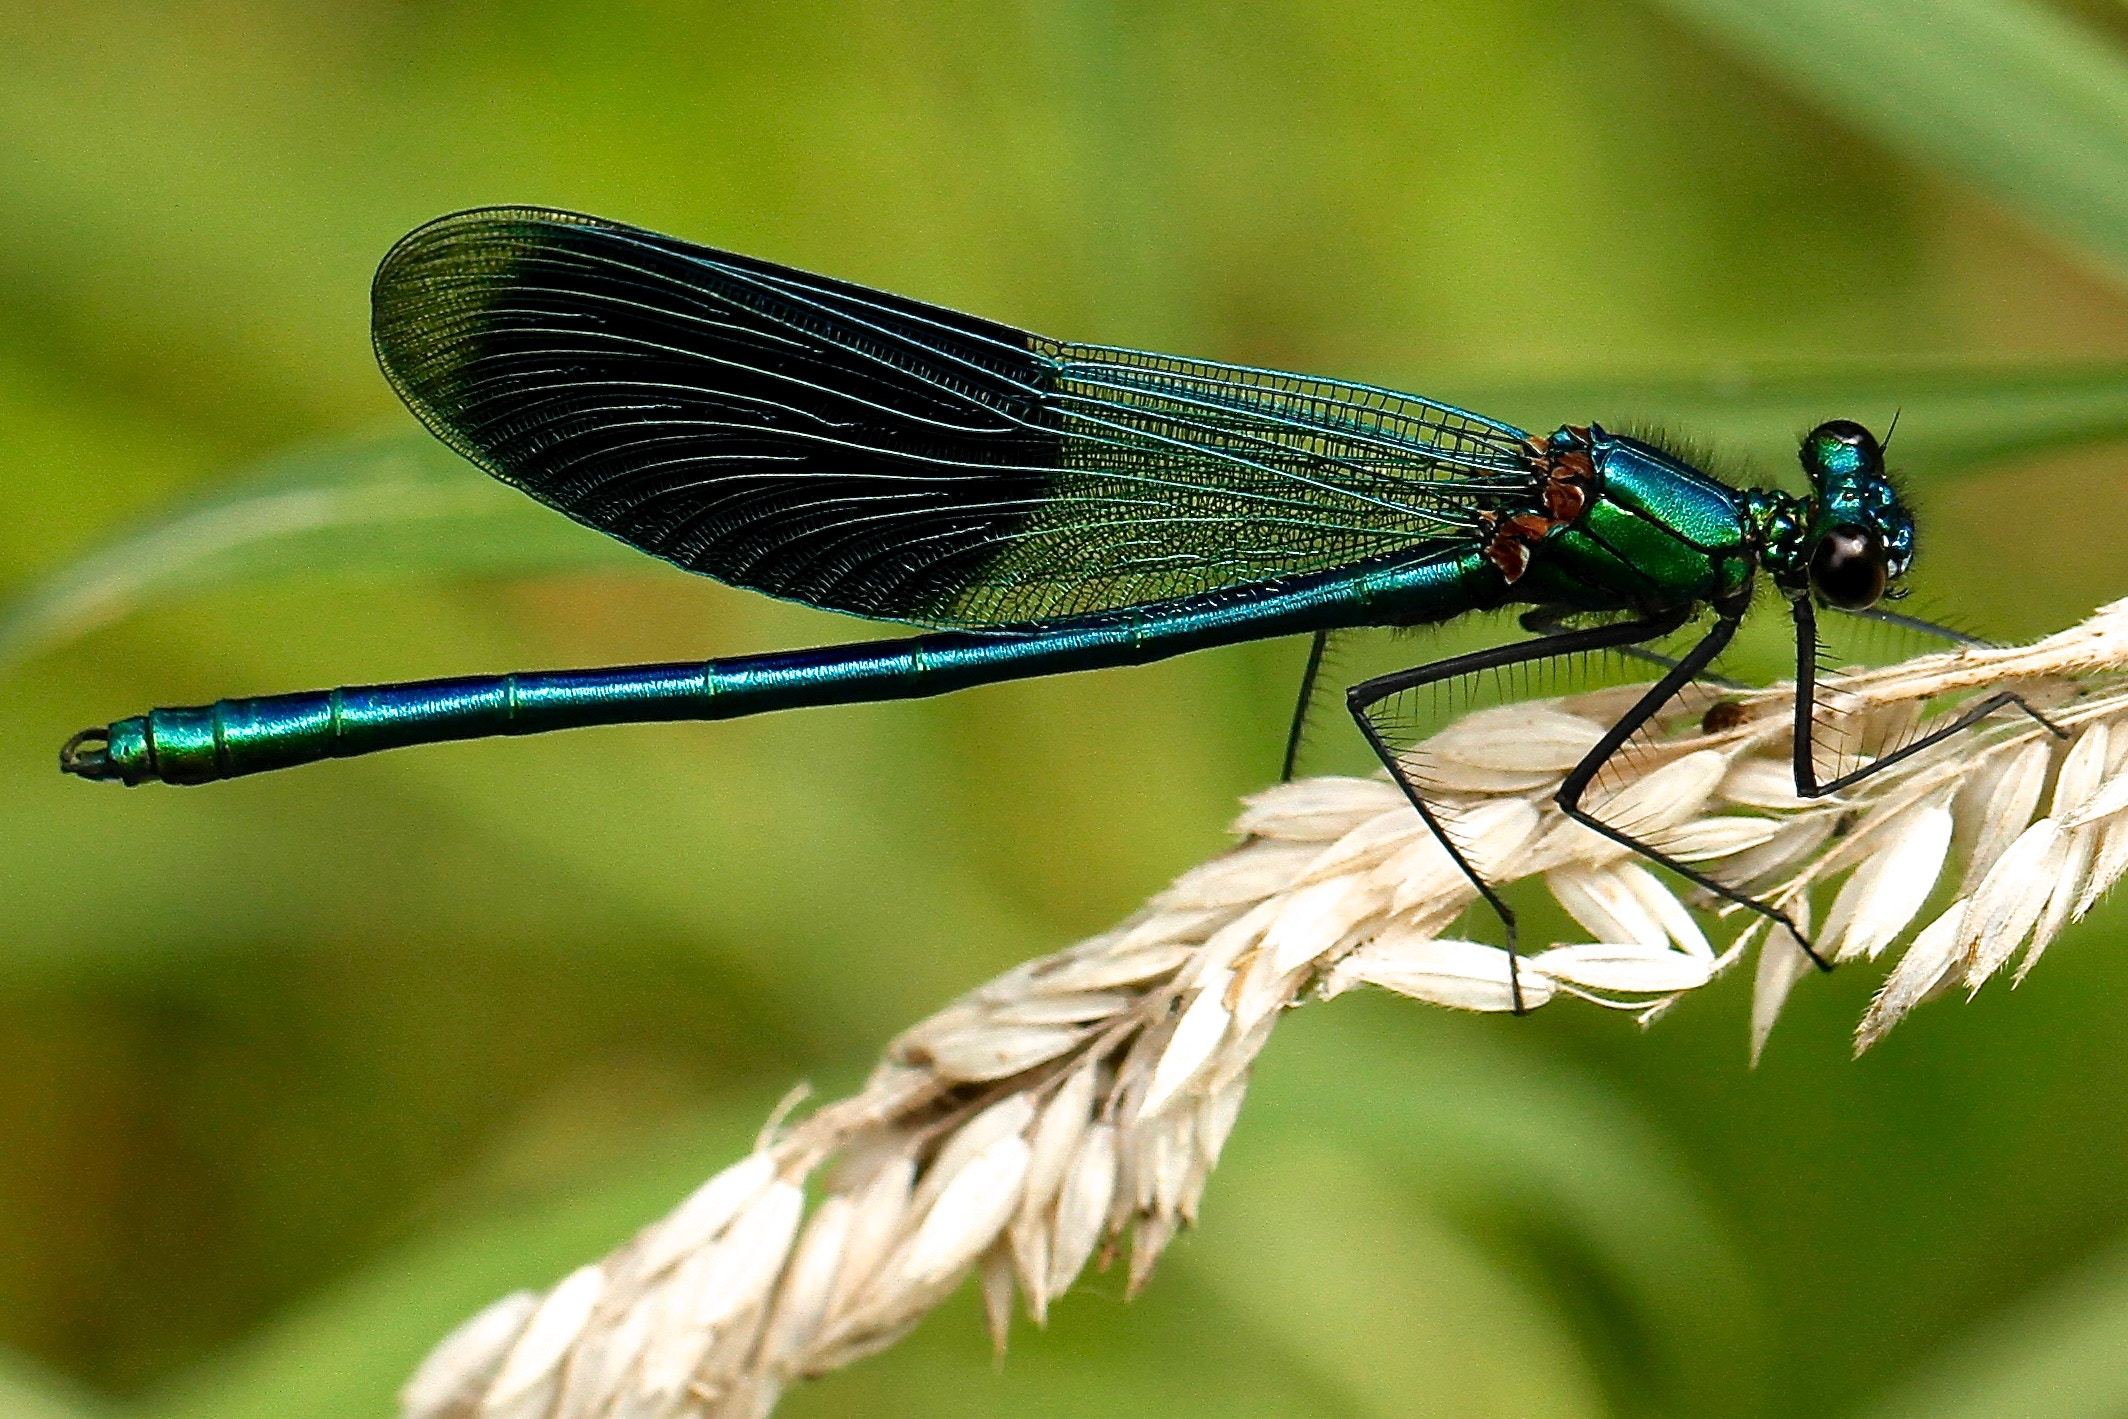

In [41]:
reference_image = 'test1.jpg'
%matplotlib inline
IPDImage(filename=reference_image, width=300) 

Your query: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2128x1419 at 0x7FE974CEE910>

Results:

1 - Catalog image ID: images/img (925).jpg  with score = 0.8036 



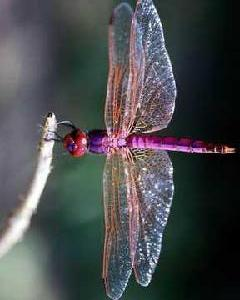

2 - Catalog image ID: images/img (927).jpg  with score = 0.7581 



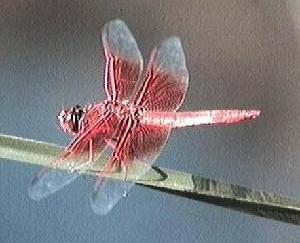

3 - Catalog image ID: images/img (930).jpg  with score = 0.75734 



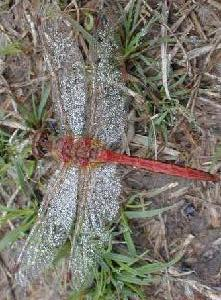


Done in 0.25317 secs


[{'corpus_id': 924, 'score': 0.8035961389541626},
 {'corpus_id': 926, 'score': 0.7581019997596741},
 {'corpus_id': 930, 'score': 0.7573397755622864}]

In [42]:
search(Image.open(reference_image), topn=3)

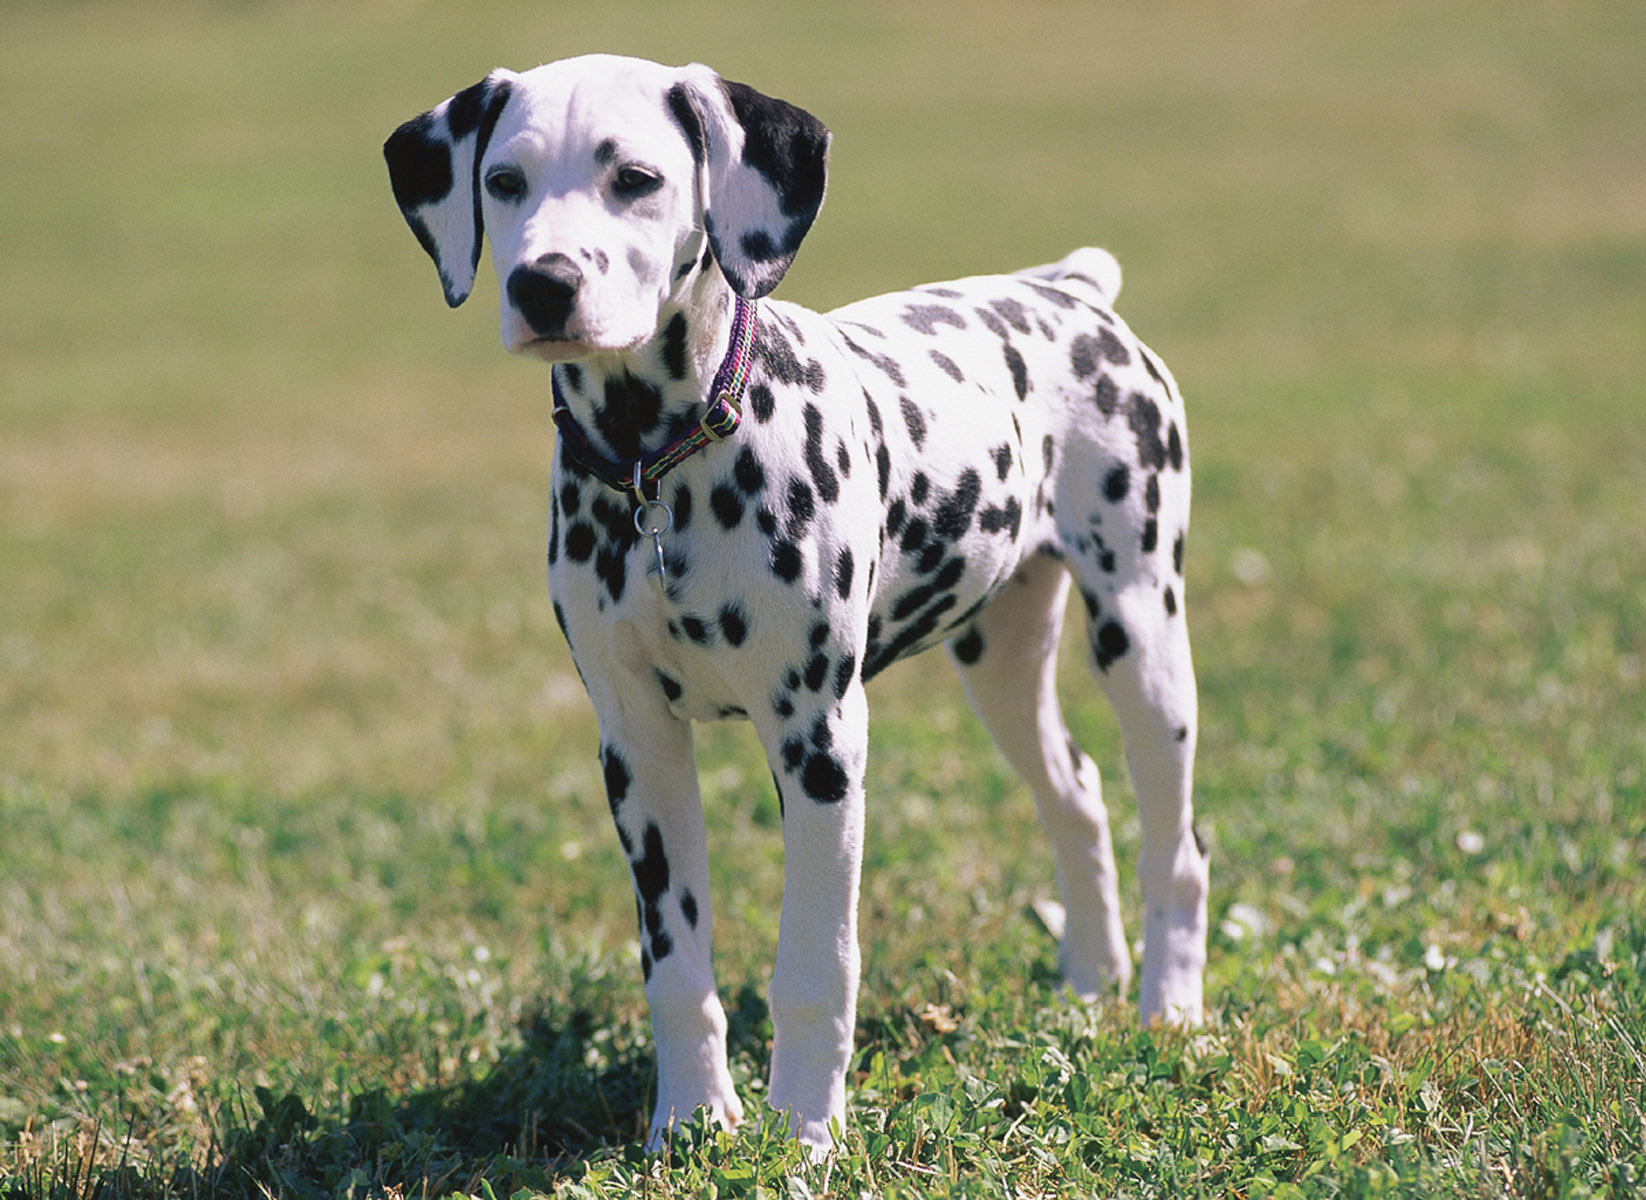

In [43]:
reference_image = 'test2.jpg'
%matplotlib inline
IPDImage(filename=reference_image, width=200) 

Your query: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1646x1200 at 0x7FE974D11F70>

Results:

1 - Catalog image ID: images/img (303).jpg  with score = 0.88467 



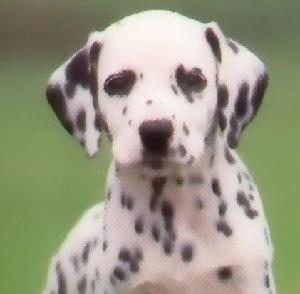

2 - Catalog image ID: images/img (302).jpg  with score = 0.87608 



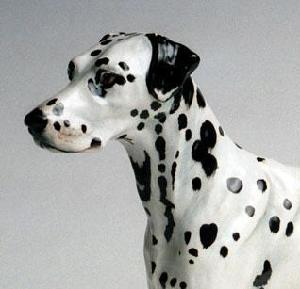

3 - Catalog image ID: images/img (309).jpg  with score = 0.87292 



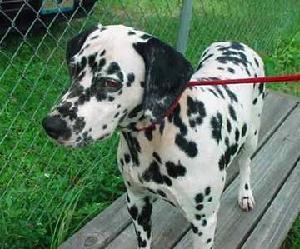

4 - Catalog image ID: images/img (353).jpg  with score = 0.85564 



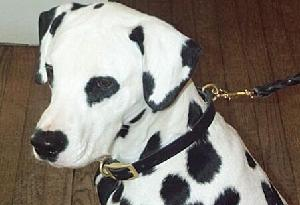

5 - Catalog image ID: images/img (342).jpg  with score = 0.85436 



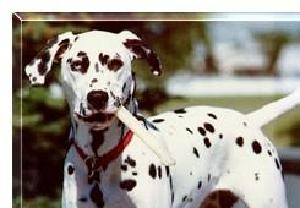


Done in 0.34167 secs


[{'corpus_id': 238, 'score': 0.8846662044525146},
 {'corpus_id': 237, 'score': 0.8760776519775391},
 {'corpus_id': 244, 'score': 0.8729239702224731},
 {'corpus_id': 293, 'score': 0.8556374311447144},
 {'corpus_id': 281, 'score': 0.8543562889099121}]

In [44]:
search(Image.open(reference_image), topn=5)

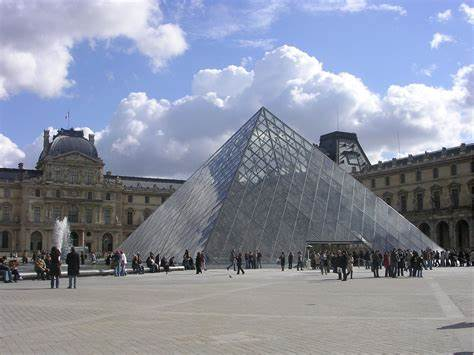

In [45]:
reference_image = 'test4.jpg'
%matplotlib inline
IPDImage(filename=reference_image, width=200) 

Your query: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x355 at 0x7FE919E67A60>

Results:

1 - Catalog image ID: images/img (975).jpg  with score = 0.86128 



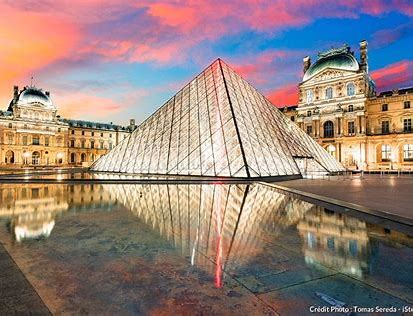


Done in 0.11817 secs


[{'corpus_id': 979, 'score': 0.8612767457962036}]

In [46]:
search(Image.open(reference_image), topn=1)

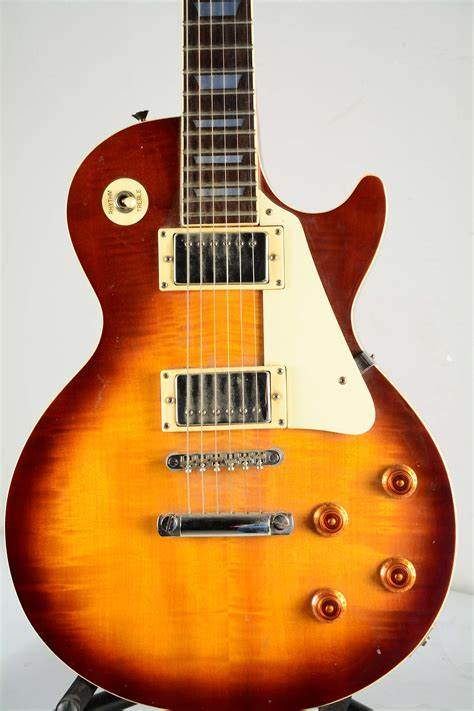

In [47]:
reference_image = 'test5.jpg'
%matplotlib inline
IPDImage(filename=reference_image, width=200) 

Your query: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x711 at 0x7FE974D11EE0>

Results:

1 - Catalog image ID: images/img (969).jpg  with score = 0.93727 



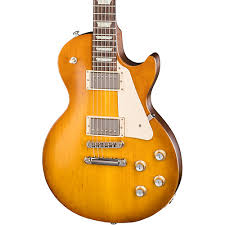

2 - Catalog image ID: images/img (966).jpg  with score = 0.92248 



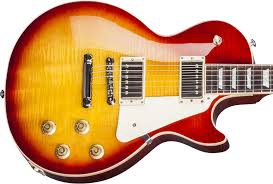

3 - Catalog image ID: images/img (967).jpg  with score = 0.91968 



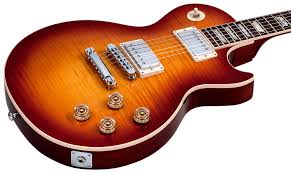

4 - Catalog image ID: images/img (956).jpg  with score = 0.91407 



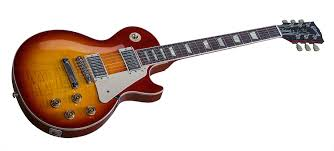

5 - Catalog image ID: images/img (963).jpg  with score = 0.91233 



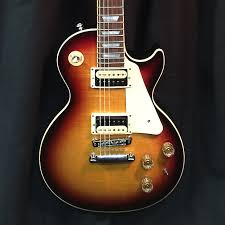


Done in 0.32939 secs


[{'corpus_id': 972, 'score': 0.9372730255126953},
 {'corpus_id': 969, 'score': 0.9224765300750732},
 {'corpus_id': 970, 'score': 0.9196774959564209},
 {'corpus_id': 958, 'score': 0.9140678644180298},
 {'corpus_id': 966, 'score': 0.912333607673645}]

In [48]:
search(Image.open(reference_image), topn=5)

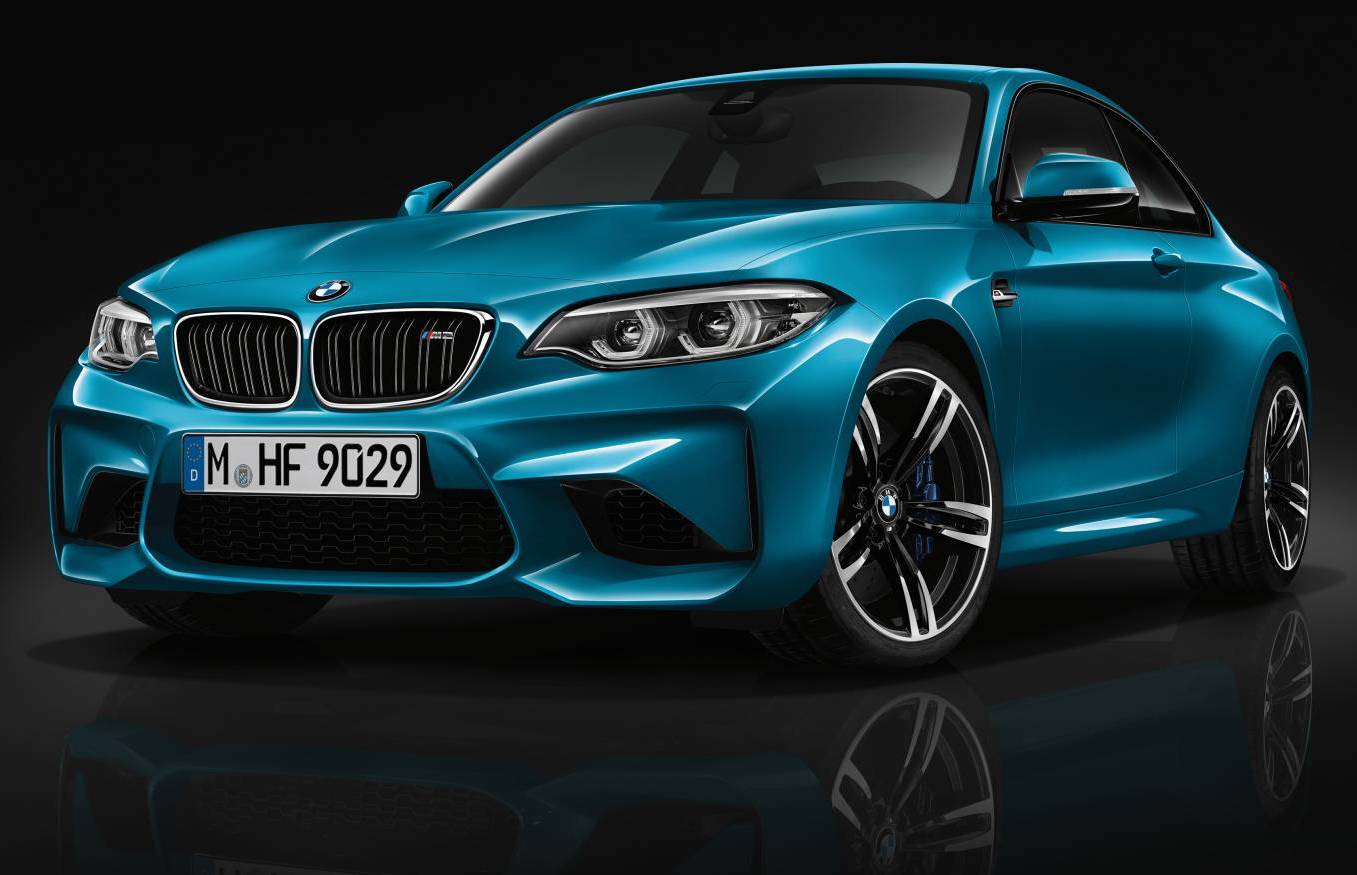

In [49]:
reference_image = 'test6.jpg'
%matplotlib inline
IPDImage(filename=reference_image, width=200) 

Your query: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1357x875 at 0x7FE974DD47F0>

Results:

1 - Catalog image ID: images/img (153).jpg  with score = 0.85772 



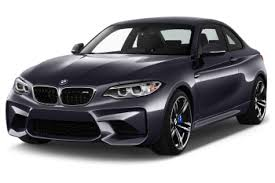

2 - Catalog image ID: images/img (152).jpg  with score = 0.79776 



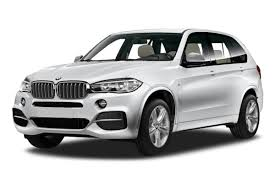

3 - Catalog image ID: images/img (151).jpg  with score = 0.79547 



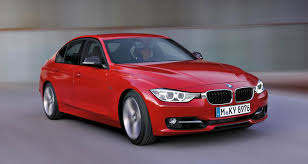


Done in 0.23419 secs


[{'corpus_id': 73, 'score': 0.8577221035957336},
 {'corpus_id': 72, 'score': 0.7977641224861145},
 {'corpus_id': 71, 'score': 0.7954732179641724}]

In [50]:
search(Image.open(reference_image), topn=3)

### Testing downloading an image

In [51]:
download_url = "https://i.pinimg.com/originals/45/77/e6/4577e66e9cd76433bf614b0ca04a6312.jpg"
reference_image = "download1.jpg"
urllib.request.urlretrieve(download_url, filename=reference_image)

('download1.jpg', <http.client.HTTPMessage at 0x7fe974817850>)

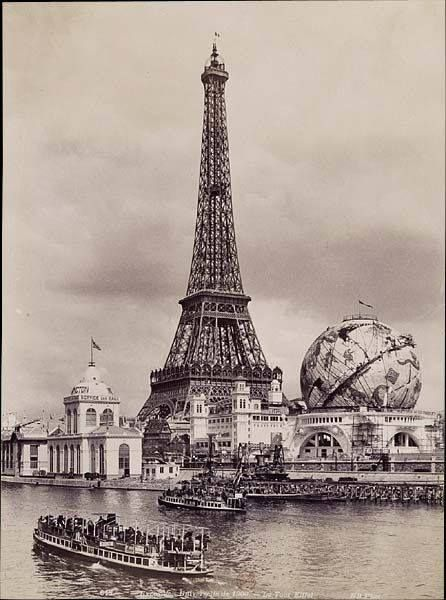

In [52]:
%matplotlib inline
IPDImage(filename=reference_image, width=250) 

Your query: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=446x600 at 0x7FE974817880>

Results:

1 - Catalog image ID: images/img (992).jpg  with score = 0.8149 



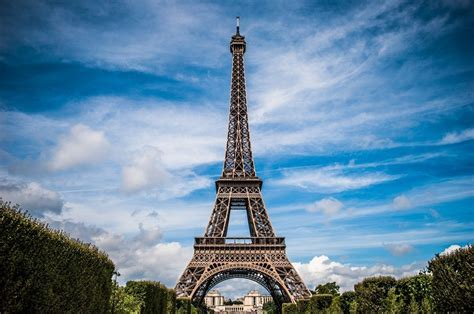

2 - Catalog image ID: images/img (991).jpg  with score = 0.81311 



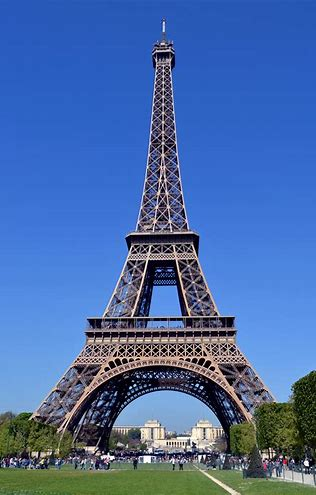

3 - Catalog image ID: images/img (974).jpg  with score = 0.81277 



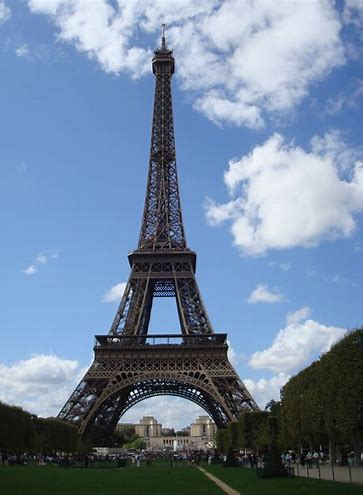


Done in 0.22464 secs


[{'corpus_id': 998, 'score': 0.8149018287658691},
 {'corpus_id': 997, 'score': 0.813110888004303},
 {'corpus_id': 978, 'score': 0.81276535987854}]

In [53]:
search(Image.open(reference_image), topn=3)

In [54]:
download_url = "https://www.marinehome.fr/wp-content/uploads/2019/07/5067_n9qm1fmppd_2920.jpg"
reference_image = "download2.jpg"
urllib.request.urlretrieve(download_url, filename=reference_image)

('download2.jpg', <http.client.HTTPMessage at 0x7fe919e870d0>)

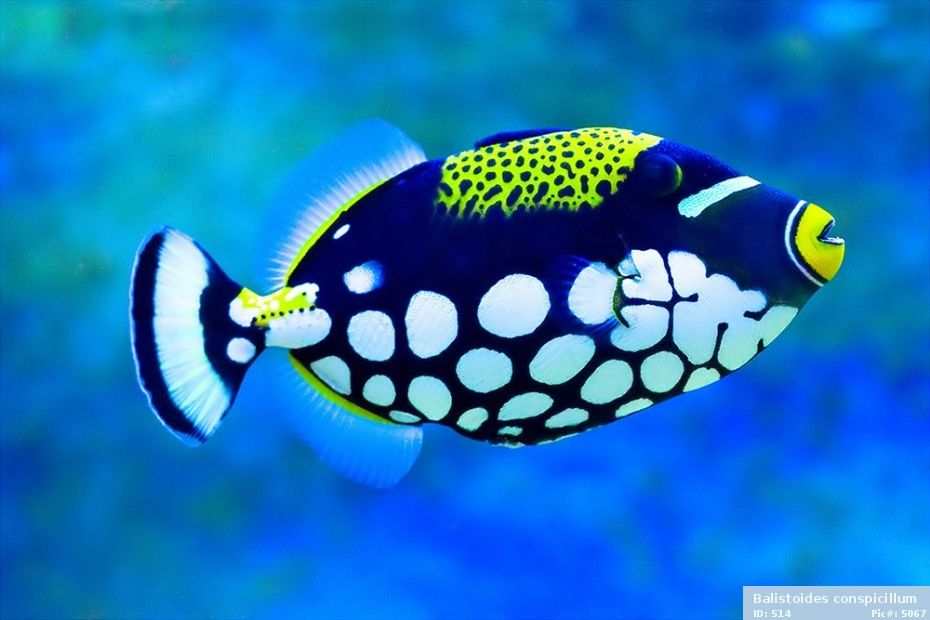

In [55]:
%matplotlib inline
IPDImage(filename=reference_image, width=250) 

Your query: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=930x620 at 0x7FE974DD4E50>

Results:

1 - Catalog image ID: images/img (146).jpg  with score = 0.88034 



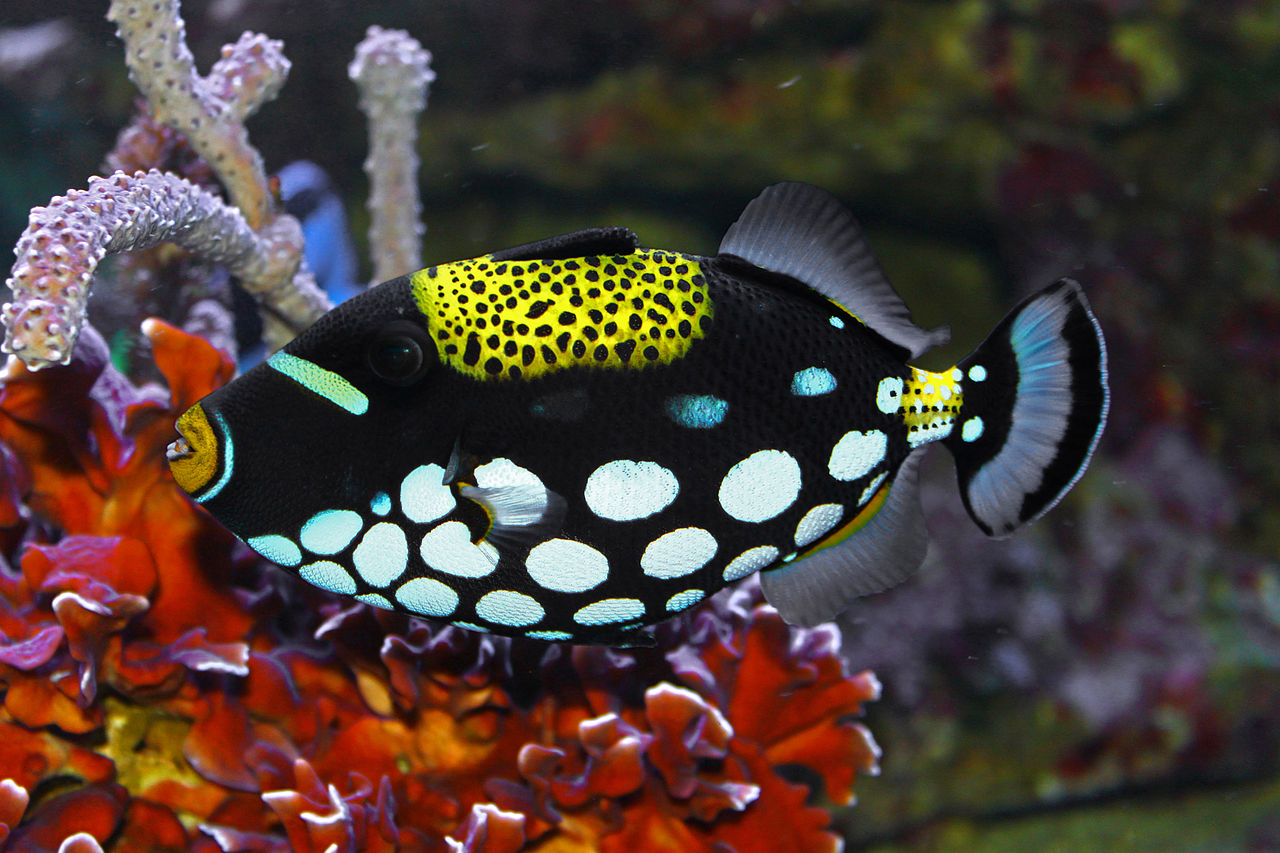

2 - Catalog image ID: images/img (141).jpg  with score = 0.87843 



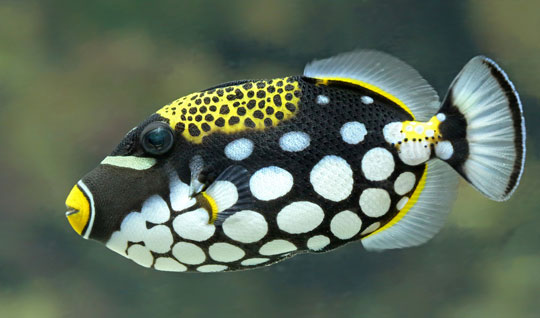

3 - Catalog image ID: images/img (143).jpg  with score = 0.8597 



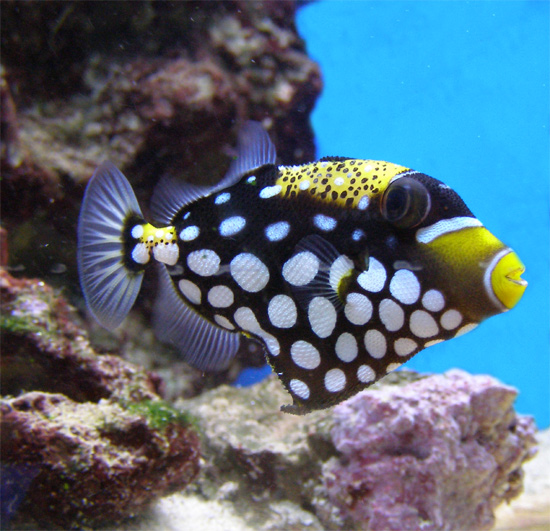

4 - Catalog image ID: images/img (145).jpg  with score = 0.85349 



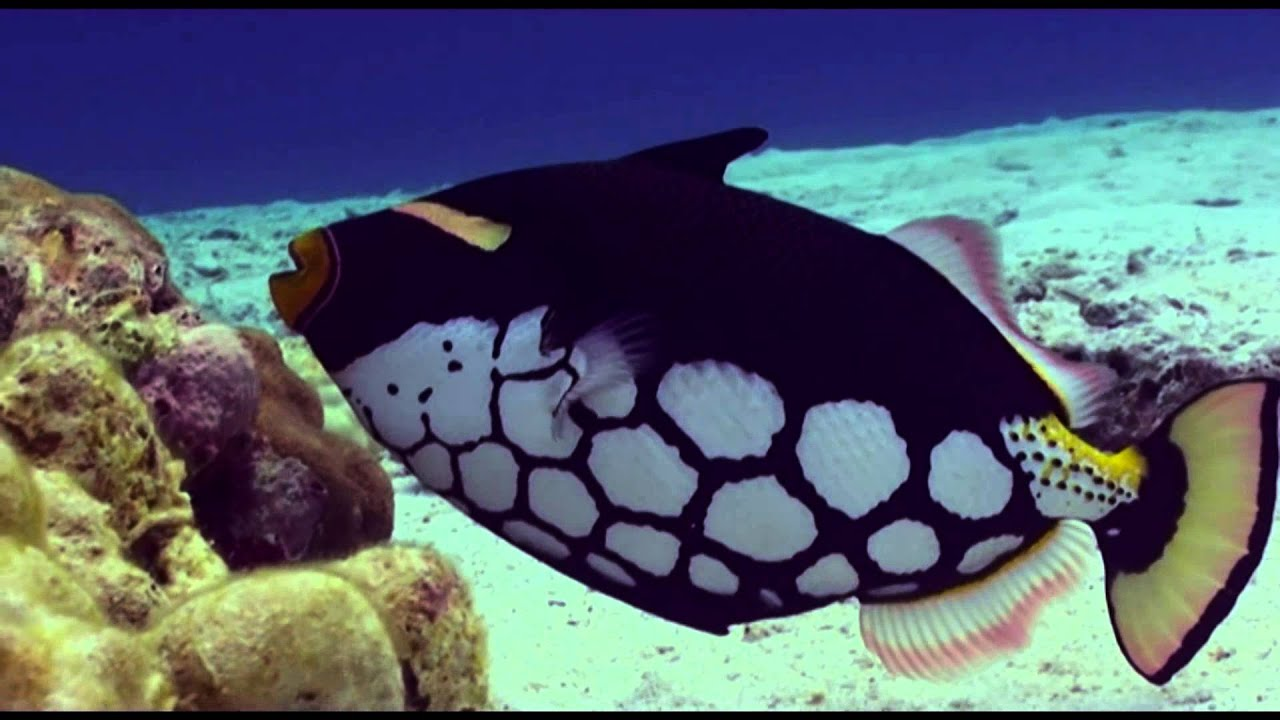

5 - Catalog image ID: images/img (140).jpg  with score = 0.85025 



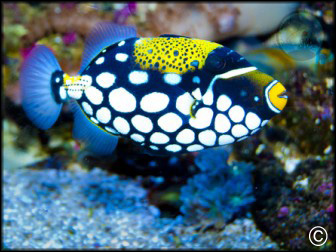


Done in 0.29835 secs


[{'corpus_id': 65, 'score': 0.8803412914276123},
 {'corpus_id': 60, 'score': 0.8784345984458923},
 {'corpus_id': 62, 'score': 0.8597049117088318},
 {'corpus_id': 64, 'score': 0.8534912467002869},
 {'corpus_id': 59, 'score': 0.8502528071403503}]

In [56]:
search(Image.open(reference_image), topn=5)